In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from dataset_loading import CocoLoader
import torch
import numpy as np
from matplotlib import colormaps
import torchvision
import os

import sam_utils
import utils

In [2]:

#CUDA tests
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #might not be viable, check again!

print("CUDA available:" + str(torch.cuda.is_available()))
from torch.utils.cpp_extension import CUDA_HOME
print("CUDA_HOME:" + str(CUDA_HOME))
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#wont work for some reason
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)
print(torch.cuda.device_count())


CUDA available:True
CUDA_HOME:/home.stud/svobo114/.conda/envs/detect_env_clone
1


# COCO testing

In [3]:
coco=CocoLoader() 
transforms = None
data_train, api = coco.load_train(transformations=transforms)
#data_val, api = coco.load_val(transformations=transforms) 



loading annotations into memory...
Done (t=16.56s)
creating index...
index created!
loading annotations into memory...
Done (t=8.86s)
creating index...
index created!


23933803
9524577


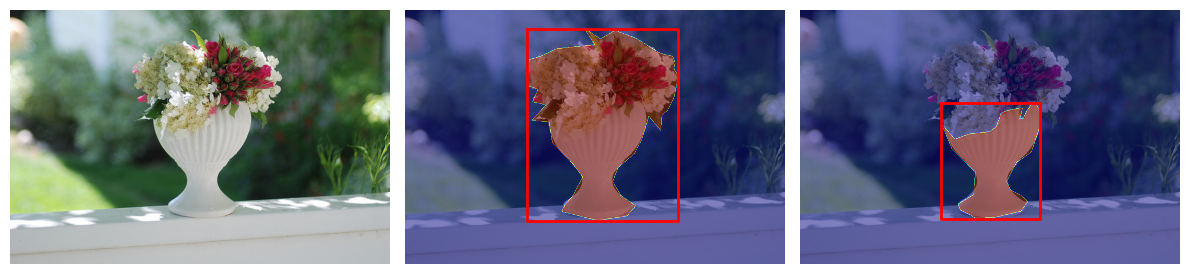

37360806


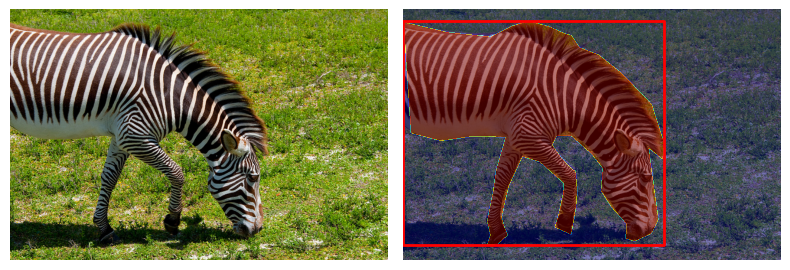

In [10]:
images_to_show =2
offset=2
scale=4

for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    num_imgs = len(metadata)+1
    fig, axes = plt.subplots(1, num_imgs, figsize=(num_imgs * scale,  scale))
    axes=axes.flatten()

    for i,ax in enumerate(axes):
        if i==0: #straight up image
            ax.imshow(img)
            ax.axis('off')

        else: #+ masks
            rle = metadata[i-1]
            mask = api.annToMask(rle)
            ax.axis('off')
            ax.imshow(img)
            ax.imshow(mask, cmap='jet', alpha=0.5)

            box = rle['bbox']
            ax.plot([box[0], box[0] + box[2], box[0] + box[2], box[0], box[0]],
                    [box[1], box[1], box[1] + box[3], box[1] + box[3], box[1]],
                    color='red', linewidth=2)
    plt.tight_layout()
    plt.show()



[162.57, 226.56, 130.41, 184.43]
[81.7, 244.94, 83.71, 158.2]
[203.39, 260.43, 65.69, 73.04]
[118.43, 261.32, 56.91, 62.93]
[119.34, 334.21, 11.94, 33.57]
[201.77, 426.19, 70.84, 47.23]
[284.34, 333.4, 10.88, 27.43]
[191.0, 334.37, 7.16, 23.41]
[346.76, 333.4, 14.8, 9.22]


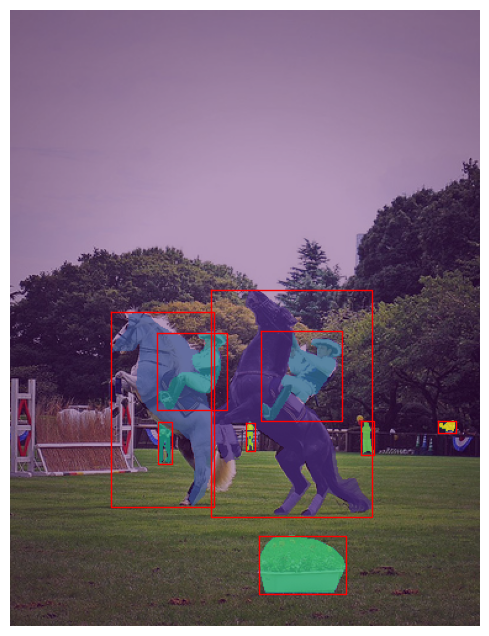

[261.2, 205.92, 48.08, 57.24]
[393.39, 210.34, 32.53, 39.74]
[370.11, 248.9, 83.09, 47.64]
[223.25, 250.1, 141.92, 77.71]
[261.54, 196.57, 34.21, 54.18]


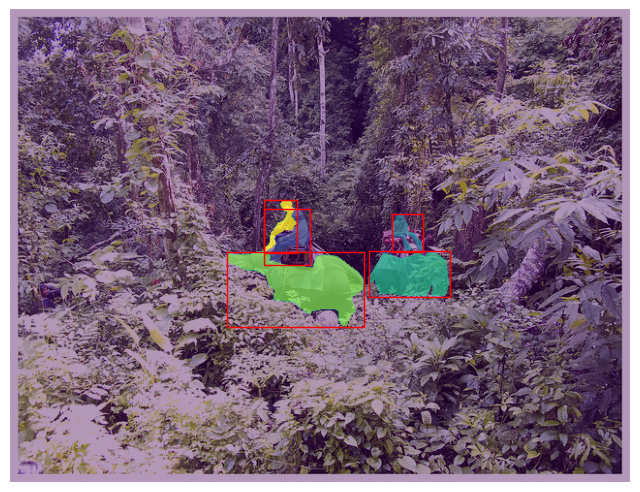

In [8]:
images_to_show =2
offset=6
scale=8
opacity=0.8
BG_MASK=True


for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    plt.figure(figsize=(scale, scale))
    plt.imshow(img) #first image
    plt.axis('off')

    cmap =colormaps['autumn']
    num_images = len(metadata)
    alpha = np.ones_like(img)[:,:,0]*opacity

    mask_sum = np.zeros_like(img)[:,:,0]
    for i,rle in enumerate(metadata):
        mask = api.annToMask(rle)
        mask_sum = np.maximum(mask_sum,mask*(i+1))
    if not BG_MASK: alpha[np.where(mask_sum==0)] = 0
    else: alpha[np.where(mask_sum==0)] = opacity/2
    plt.imshow(mask_sum, cmap='viridis', alpha=alpha) #TODO:  show just the masked part with color and not the rest?

    for i,rle in enumerate(metadata): #all masks
        box = rle['bbox'] #still x0,y0,w,h boxes here!!
        utils.
        plt.plot([box[0], box[0] + box[2], box[0] + box[2], box[0], box[0]],
                [box[1], box[1], box[1] + box[3], box[1] + box[3], box[1]],
                #color=cmap(i/num_images), linewidth=1)
                color='red', linewidth=1)

    plt.show()


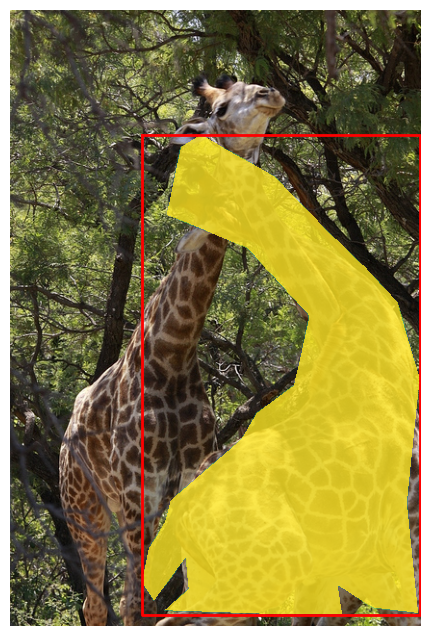

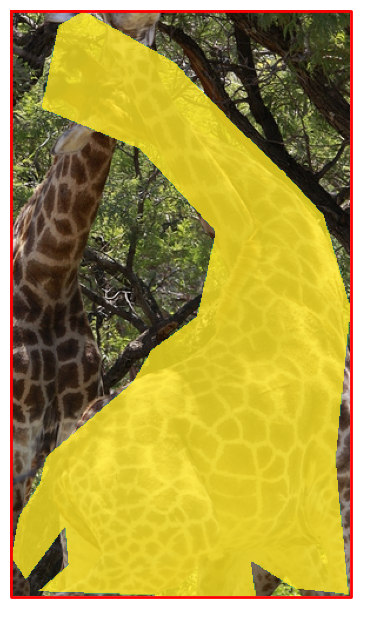

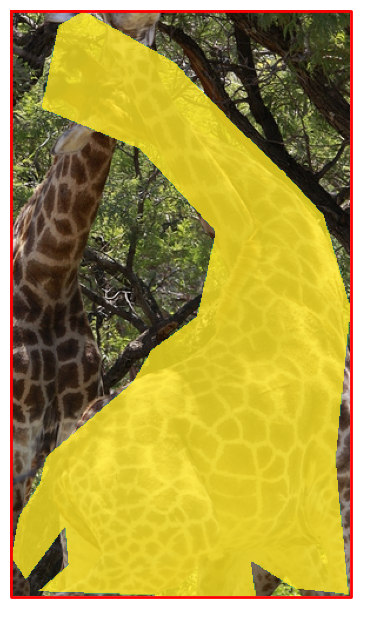

In [5]:
#all crops work? on PIL Image and numpy array

img = data_train[10][0] 
metadata = data_train[10][1]

gt_masks = utils.get_coco_masks(metadata, api)
gt_bboxes = utils.get_coco_boxes(metadata)

#img=np.asarray(img)
mask=gt_masks[0]
box=gt_bboxes[0]

sam_utils.print_masks_boxes([mask], [box], img)

x0,y0=box[0],box[1]
w,h = box[2]-box[0],box[3]-box[1]
cropped_img,cropped_mask,cropped_box = sam_utils.crop_xywh(img,mask,box,x0,y0,w,h)
sam_utils.print_masks_boxes([cropped_mask], [cropped_box], cropped_img)

x1,y1 = box[2],box[3]
cropped_img,cropped_mask,cropped_box = sam_utils.crop_xyxy(img,mask,box,x0,y0,x1,y1)
sam_utils.print_masks_boxes([cropped_mask], [cropped_box], cropped_img)